In [1]:
import os
import json

In [88]:
from functools import partial

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from astropy.stats import sigma_clip

In [82]:
from scipy.signal import savgol_filter
from scipy.optimize import minimize

In [3]:
from tqdm.auto import tqdm

In [4]:
import scipy

In [5]:
from sklearn.linear_model import Ridge, LinearRegression

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
from xgboost import XGBRegressor

In [85]:
from concurrent.futures import ProcessPoolExecutor

## Load Data

In [84]:
nums_parallel = 48

In [7]:
DATA_ROOT = '../input/'

In [8]:
cut_inf, cut_sup = 39, 321

### 未对空间维度进行trim去噪

In [9]:
train_processed = np.load('train_processed.npz')
f_raw_train, a_raw_train = train_processed['f_raw_train'], train_processed['a_raw_train']

In [10]:
a_raw_train = a_raw_train[:, :, cut_inf:cut_sup]

In [11]:
a_raw_train_mean = a_raw_train.mean(axis=-1)

In [12]:
f_raw_train.shape, a_raw_train.shape, a_raw_train_mean.shape

((673, 67500), (673, 5625, 282), (673, 5625))

### 对空间维度进行trim去噪

In [128]:
train_processed = np.load('trim_train_processed.npz')
trim_f_raw_train, trim_a_raw_train = train_processed['f_raw_train'], train_processed['a_raw_train']

In [129]:
trim_a_raw_train = trim_a_raw_train[:, :, cut_inf:cut_sup]

In [130]:
trim_a_raw_train_mean = trim_a_raw_train.mean(axis=-1)

In [131]:
trim_f_raw_train.shape, trim_a_raw_train.shape, trim_a_raw_train_mean.shape

((673, 67500), (673, 5625, 282), (673, 5625))

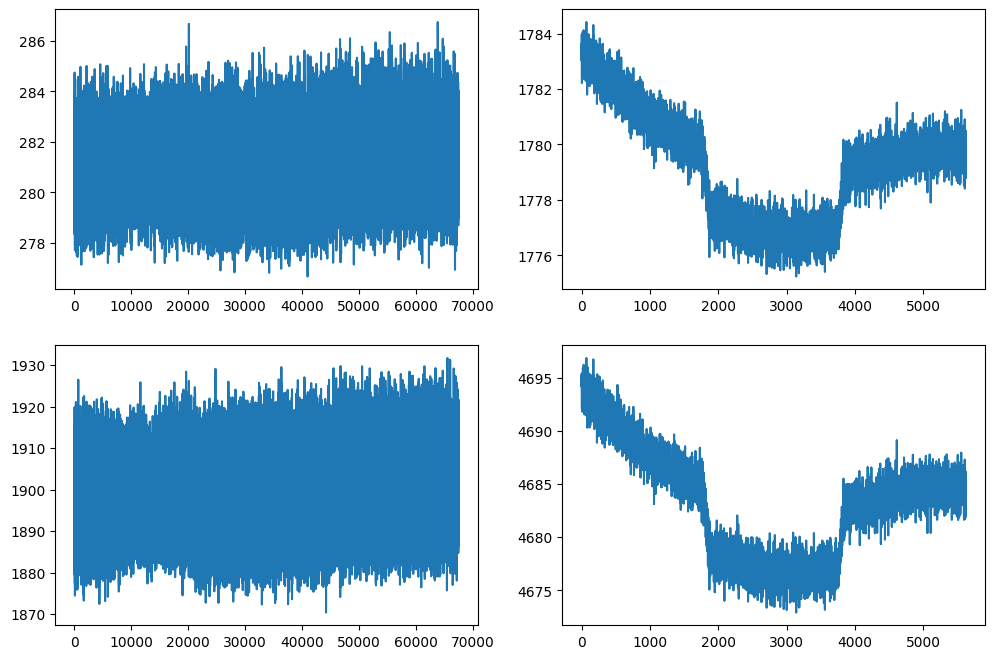

In [138]:
i = 0
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(f_raw_train[i])

plt.subplot(2, 2, 2)
plt.plot(a_raw_train_mean[i])

plt.subplot(2, 2, 3)
plt.plot(trim_f_raw_train[i])

plt.subplot(2, 2, 4)
plt.plot(trim_a_raw_train_mean[i])

In [140]:
f_raw_train[i].mean() / f_raw_train[i].std(), trim_f_raw_train[i].mean() / trim_f_raw_train[i].std()

(220.64658, 221.1398)

In [142]:
a_raw_train[i].mean() / a_raw_train_mean[i].std(), trim_a_raw_train[i].mean() / trim_a_raw_train_mean[i].std()

(913.91473, 919.49634)

In [72]:
# train_adc_df = pd.read_csv(f'{DATA_ROOT}/train_adc_info.csv', index_col='planet_id')
train_adc_df = pd.read_pickle('train_adc_info_with_transit_zone.pkl')

In [14]:
train_label_df = pd.read_csv(f'{DATA_ROOT}/train_labels.csv', index_col='planet_id')

In [15]:
wavelengths = pd.read_csv(f'{DATA_ROOT}/wavelengths.csv')

In [16]:
axis_info = pd.read_parquet(f'{DATA_ROOT}/axis_info.parquet')

## Metric

In [17]:
def get_cv_score(pred_array, sigma_pred):
    sub_df = create_submission(pred_array, train_label_df.index, sigma_pred)
    score = competition_score(
        solution=train_label_df,
        submission=sub_df,
        naive_mean=train_label_df.values.mean(),
        naive_sigma=train_label_df.values.std(),
        sigma_true=10e-6,  # 10ppm
    )
    return score

def create_submission(pred_array, index, sigma_pred):
    """Create a submission dataframe from its components
    
    Parameters:
    pred_array: ndarray of shape (n_samples, 283)
    index: pandas.Index of length n_samples with name 'planet_id'
    sigma_pred: float
    
    Return value:
    df: DataFrame of shape (n_samples, 566) with planet_id as index
    """
    return pd.concat([pd.DataFrame(pred_array.clip(0, None), index=index, columns=wavelengths.columns),
                      pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i}" for i in range(1, 284)])],
                     axis=1)

# Adapted from https://www.kaggle.com/code/metric/ariel-gaussian-log-likelihood
class ParticipantVisibleError(Exception):
    pass

def competition_score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        naive_mean: float,
        naive_sigma: float,
        sigma_true: float,
    ) -> float:
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths*2:
        raise ParticipantVisibleError('Wrong number of columns in the submission')

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None)
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))

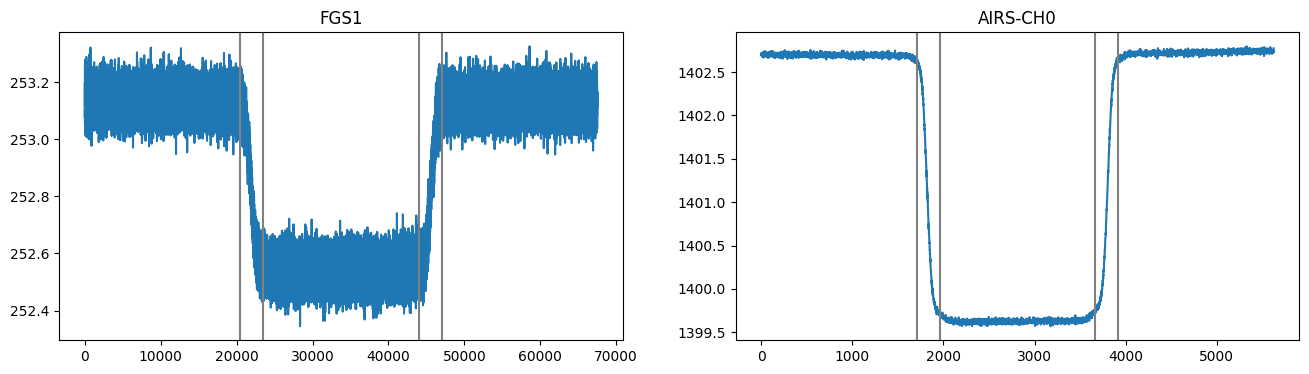

In [18]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(f_raw_train.mean(axis=0))
plt.title('FGS1')
for bp in [20500, 23500, 44000, 47000]:
    plt.axvline(bp, color='gray')

plt.subplot(1, 2, 2)
plt.plot(a_raw_train_mean.mean(axis=0))
plt.title('AIRS-CH0')
for bp in [1708, 1958, 3666, 3916]:
    plt.axvline(bp, color='gray')

用每个行星的凌日深度的均值，作为各波段的预测

In [19]:
out_transit = np.column_stack([
    a_raw_train_mean[:, :1708], 
    a_raw_train_mean[:, 3916:]
])

in_transit = a_raw_train_mean[:, 1958:3666]

out_transit.shape, in_transit.shape

((673, 3417), (673, 1708))

In [20]:
out_transit = out_transit.mean(axis=-1)
in_transit = in_transit.mean(axis=-1)

In [21]:
depth = (out_transit - in_transit) / out_transit

In [22]:
depth2 = (out_transit - in_transit) / in_transit

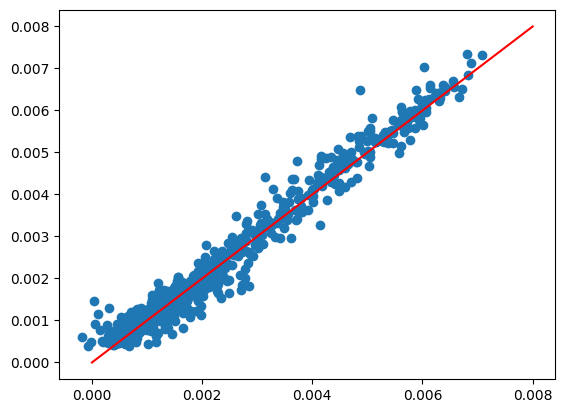

In [23]:
plt.scatter(depth, train_label_df.mean(axis=1).values)
plt.plot([0, 0.008], [0, 0.008], color='red')

In [24]:
depth.shape

(673,)

In [25]:
pred = np.tile(depth.reshape(-1, 1), (1, 283))

In [26]:
sigma_pred = mean_squared_error(train_label_df.values, pred, squared=False)
sigma_pred

0.00032169657880511853

In [27]:
get_cv_score(pred, sigma_pred)

0.29745461391318345

In [28]:
pred = np.tile(depth2.reshape(-1, 1), (1, 283))

In [29]:
sigma_pred = mean_squared_error(train_label_df.values, pred, squared=False)
sigma_pred

0.0003196858793447398

In [30]:
get_cv_score(pred, sigma_pred)

0.29858917841141663

## Cross Validation

## Feature Engineering

### 拟合凌日深度

In [80]:
FGS1_BUFFER_SIZE = 1500
AIRS_BUFFER_SIZE = 120

In [81]:
def try_s(sensor, signal, p1, p2, deg, s):
    buffer_size = AIRS_BUFFER_SIZE if sensor == 'AIRS-CH0' else FGS1_BUFFER_SIZE

    out1_start, out1_end = 0, p1 - buffer_size
    in_start, in_end = p1 + buffer_size, p2 - buffer_size
    out2_start, out2_end = p2 + buffer_size, signal.shape[0]
    
    out = list(range(out1_start, out1_end)) + list(range(out2_start, out2_end))
    x, y = out, signal[out].tolist()
    x = x + list(range(in_start, in_end))
    y = y + (signal[in_start:in_end] * (1 + s[0])).tolist()
    
    z = np.polyfit(x, y, deg)
    p = np.poly1d(z)
    q = np.abs(p(x) - y).mean()

    if s < 1e-4:
        return q + 1e3

    return q


def fit_transit_depth(sensor, signal, breakpoints):
    p1, p2 = breakpoints
    
    buffer_size = AIRS_BUFFER_SIZE if sensor == 'AIRS-CH0' else FGS1_BUFFER_SIZE
    out1_start, out1_end = 0, p1 - buffer_size
    in_start, in_end = p1 + buffer_size, p2 - buffer_size
    out2_start, out2_end = p2 + buffer_size, signal.shape[0]
    
    best_deg, best_score = 1, 1e12
    best_s = None
    for deg in range(1, 3):
        f = partial(try_s, sensor, signal, p1, p2, deg)
        r = minimize(f, [0.001], method = 'Nelder-Mead')
        s = r.x[0]

        out = list(range(out1_start, out1_end)) + list(range(out2_start, out2_end))
        x, y = out, signal[out].tolist()
        x = x + list(range(in_start, in_end))
        y = y + (signal[in_start:in_end] * (1 + s)).tolist()
    
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        
        if q < best_score:
            best_score = q
            best_deg = deg
            best_s = s

        # print(deg, q, s)
        
    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)
    
    return best_s, p(np.arange(signal.shape[0]))

In [86]:
def fit_task(f_raw, a_raw, breakpoints):
    f_depth, _ = fit_transit_depth('FGS1', f_raw, [x * 12 for x in breakpoints['AIRS-CH0']])
    a_depth, _ = fit_transit_depth('AIRS-CH0', a_raw, breakpoints['AIRS-CH0'])
    return f_depth, a_depth

In [89]:
with ProcessPoolExecutor(nums_parallel) as exe:
    all_depth = list( tqdm(exe.map(fit_task, f_raw_train, a_raw_train_mean, train_adc_df.breakpoints), total=train_adc_df.shape[0]) )

  0%|          | 0/673 [00:00<?, ?it/s]

In [90]:
train_adc_df['all_depth'] = all_depth
train_adc_df['f_depth2'] = train_adc_df.all_depth.apply(lambda x: x[0])
train_adc_df.f_depth2 = train_adc_df.f_depth.clip(0)

In [92]:
(train_adc_df.f_depth == train_adc_df.f_depth2).mean()

1.0

#### trim版

In [143]:
with ProcessPoolExecutor(nums_parallel) as exe:
    all_depth = list( tqdm(exe.map(fit_task, trim_f_raw_train, trim_a_raw_train_mean, train_adc_df.breakpoints), total=train_adc_df.shape[0]) )

  0%|          | 0/673 [00:00<?, ?it/s]

In [145]:
train_adc_df['all_depth'] = all_depth
train_adc_df['trim_f_depth'] = train_adc_df.all_depth.apply(lambda x: x[0])
train_adc_df['trim_a_depth'] = train_adc_df.all_depth.apply(lambda x: x[1])
train_adc_df.trim_f_depth = train_adc_df.trim_f_depth.clip(0)
train_adc_df.trim_a_depth = train_adc_df.trim_a_depth.clip(0)

In [146]:
train_adc_df.head()

,FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain,star,breakpoints,r0,r1,f_depth,a_depth,all_depth,f_depth2,a_wv_depth,trim_f_depth,trim_a_depth
planet_id,,,,,,,,,,,,,,,
785834,-343.335938,0.837244,-778.916533,0.924746,1,"{'AIRS-CH0': [1779, 3845], 'FGS1': [21374, 461...",12.014615,11.996359,0.00105,0.001300,"(0.001400000000000001, 0.0012625000000000006)",0.00105,"[0.001, 0.001, 0.00015, 0.00105, 0.0002, 0.001...",0.00140,0.001263
14485303,-366.381992,0.842983,-740.323212,0.931727,1,"{'AIRS-CH0': [1786, 3838], 'FGS1': [22167, 453...",12.411534,11.811621,0.00205,0.001900,"(0.0019500000000000032, 0.0018875000000000029)",0.00205,"[0.001, 0.001, 0.00105, 0.001, 0.001, 0.001, 0...",0.00195,0.001888
17002355,-386.107037,1.041701,-808.690659,1.513541,0,"{'AIRS-CH0': [1807, 3817], 'FGS1': [21432, 460...",11.860542,12.069164,0.00285,0.002725,"(0.0031000000000000077, 0.002750000000000006)",0.00285,"[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",0.00310,0.002750
24135240,-339.737490,0.840239,-776.124167,0.931277,1,"{'AIRS-CH0': [1810, 3814], 'FGS1': [22486, 450...",12.423204,11.802307,0.00105,0.001450,"(0.0011500000000000004, 0.0014500000000000014)",0.00105,"[0.001, 0.00105, 0.00105, 0.001, 0.001, 0.0002...",0.00115,0.001450
25070640,-355.660433,1.041280,-848.371494,1.503923,0,"{'AIRS-CH0': [1964, 3660], 'FGS1': [23835, 436...",12.135947,11.930328,0.00180,0.001950,"(0.0017500000000000024, 0.0020250000000000034)",0.00180,"[0.00105, 0.001, 0.001, 0.001, 0.001, 0.001, 0...",0.00175,0.002025


#### 为 AIRS 每个波段拟合凌日深度

In [110]:
def fit_every_wv(a_raw, breakpoints):
    '''
        a_raw: T x 282
    '''
    res = []
    for i in tqdm(range(282)):
        signal = a_raw[:, i]
        depth, _ = fit_transit_depth('AIRS-CH0', signal, breakpoints['AIRS-CH0'])
        res.append(depth)
    return np.array(res, dtype=np.float32).clip(0)

In [108]:
i = 0
r = train_adc_df.iloc[i]
a_raw = a_raw_train[0]
depth = fit_every_wv(a_raw, r.breakpoints)

  0%|          | 0/282 [00:00<?, ?it/s]

In [114]:
depth.shape

(282,)

In [115]:
with ProcessPoolExecutor(nums_parallel) as exe:
    all_depth = list( tqdm(exe.map(fit_every_wv, a_raw_train, train_adc_df.breakpoints), total=train_adc_df.shape[0]) )

  0%|          | 0/673 [00:00<?, ?it/s]

In [116]:
train_adc_df['a_wv_depth'] = all_depth

##### trim版

In [147]:
with ProcessPoolExecutor(nums_parallel) as exe:
    all_depth = list( tqdm(exe.map(fit_every_wv, trim_a_raw_train, train_adc_df.breakpoints), total=train_adc_df.shape[0]) )

  0%|          | 0/673 [00:00<?, ?it/s]

In [148]:
train_adc_df['trim_a_wv_depth'] = all_depth

In [149]:
train_adc_df.head()

,FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain,star,breakpoints,r0,r1,f_depth,a_depth,all_depth,f_depth2,a_wv_depth,trim_f_depth,trim_a_depth,trim_a_wv_depth
planet_id,,,,,,,,,,,,,,,,
785834,-343.335938,0.837244,-778.916533,0.924746,1,"{'AIRS-CH0': [1779, 3845], 'FGS1': [21374, 461...",12.014615,11.996359,0.00105,0.001300,"(0.001400000000000001, 0.0012625000000000006)",0.00105,"[0.001, 0.001, 0.00015, 0.00105, 0.0002, 0.001...",0.00140,0.001263,"[0.001, 0.00105, 0.0002, 0.0002, 0.000125, 0.0..."
14485303,-366.381992,0.842983,-740.323212,0.931727,1,"{'AIRS-CH0': [1786, 3838], 'FGS1': [22167, 453...",12.411534,11.811621,0.00205,0.001900,"(0.0019500000000000032, 0.0018875000000000029)",0.00205,"[0.001, 0.001, 0.00105, 0.001, 0.001, 0.001, 0...",0.00195,0.001888,"[0.001, 0.001, 0.0002, 0.00105, 0.001, 0.001, ..."
17002355,-386.107037,1.041701,-808.690659,1.513541,0,"{'AIRS-CH0': [1807, 3817], 'FGS1': [21432, 460...",11.860542,12.069164,0.00285,0.002725,"(0.0031000000000000077, 0.002750000000000006)",0.00285,"[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",0.00310,0.002750,"[0.0002, 0.001, 0.00105, 0.001, 0.00205, 0.002..."
24135240,-339.737490,0.840239,-776.124167,0.931277,1,"{'AIRS-CH0': [1810, 3814], 'FGS1': [22486, 450...",12.423204,11.802307,0.00105,0.001450,"(0.0011500000000000004, 0.0014500000000000014)",0.00105,"[0.001, 0.00105, 0.00105, 0.001, 0.001, 0.0002...",0.00115,0.001450,"[0.001, 0.001, 0.00105, 0.0002, 0.0002, 0.0010..."
25070640,-355.660433,1.041280,-848.371494,1.503923,0,"{'AIRS-CH0': [1964, 3660], 'FGS1': [23835, 436...",12.135947,11.930328,0.00180,0.001950,"(0.0017500000000000024, 0.0020250000000000034)",0.00180,"[0.00105, 0.001, 0.001, 0.001, 0.001, 0.001, 0...",0.00175,0.002025,"[0.001, 0.001, 0.001, 0.001, 0.0002, 0.00105, ..."


### 构建特征

In [31]:
airs_global_breakpoints = [1708, 1958, 3666, 3916]
fgs1_global_breakpoints = [20500, 23500, 44000, 47000]

In [74]:
def get_transit_depth(signal, breakpoints, half=False, devide_in_transit=False, single_example=False):
    '''  ----p1-p2--p3-p4----
    signal: N x T
    breakpoints: [p1, p2, p3, p4]
    half: 半凌日
    '''
    if single_example:
        signal = signal.reshape(1, -1)  # 1 x T
    
    p1, p2, p3, p4 = breakpoints
    out_transit = np.column_stack([signal[:, :p1], signal[:, p4:]])

    if half:
        in_transit = np.column_stack([signal[:, p1:p2], signal[:, p3:p4]])
    else:
        in_transit = signal[:, p2:p3]

    out_transit = out_transit.mean(axis=-1)
    in_transit = in_transit.mean(axis=-1)

    if devide_in_transit:
        depth = (out_transit - in_transit) / in_transit
    else:
        depth = (out_transit - in_transit) / out_transit
        
    depth = depth.clip(0)  # (N,)

    if single_example:
        depth = depth.item()
    
    return depth

In [39]:
def get_transit_depth_multi_wv(signal, breakpoints, half=False, devide_in_transit=False, single_example=False):
    '''  ----p1-p2--p3-p4----
    signal: N x T x 282
    breakpoints: [p1, p2, p3, p4]
    half: 半凌日
    '''
    if single_example:
        signal = signal[np.newaxis]  # 1 x T x 282
    
    p1, p2, p3, p4 = breakpoints
    out_transit = np.column_stack([signal[:, :p1], signal[:, p4:]])

    if half:
        in_transit = np.column_stack([signal[:, p1:p2], signal[:, p3:p4]])
    else:
        in_transit = signal[:, p2:p3]

    out_transit = out_transit.mean(axis=1)  # over T axis -> N x 282
    in_transit = in_transit.mean(axis=1)  # over T axis  -> N x 282

    if devide_in_transit:
        depth = (out_transit - in_transit) / in_transit
    else:
        depth = (out_transit - in_transit) / out_transit
        
    depth = depth.clip(0)  # (N, 282)

    if single_example:
        depth = depth.flatten()
    
    return depth

In [75]:
def fe_transit_depth_mean_wv(f_raw, a_raw, devide_in_transit=False, polyfit=False):
    '''
    desc:
        1.凌日起止点用整个训练集公共的
        2.airs 282个波段取平均
    input:
        f_raw: (N, 67500)
        a_raw: (N, 5625)

    return:
        ndarray of shape (N, 2)
    '''
    if polyfit:  # 多项式拟合得到的凌日深度
        return train_adc_df[['f_depth', 'a_depth']].values
    
    f_depth = get_transit_depth(f_raw, fgs1_global_breakpoints, devide_in_transit=devide_in_transit) # (N,)
    a_depth = get_transit_depth(a_raw, airs_global_breakpoints, devide_in_transit=devide_in_transit) # (N,)

    res = np.row_stack([f_depth, a_depth]).transpose()  # (N,2)
    return res

In [62]:
def fe_independent_transit_depth_mean_wv(f_raw, a_raw, airs_only=False, add_half=False):
    '''
    desc:
        1.使用find_transit_zone算法精确定位的凌日起止点
        2.airs 282个波段取平均
    input:
        airs_only: 由于airs信号更精准，可以考虑只使用airs探测到的凌日起止点，fgs1起止点可通过✖️12转换得到
    return:
        ndarray of shape (N, 2)
    '''
    res = []
    
    for f_signal, a_signal, breakpoints in tqdm(zip(f_raw, a_raw, train_adc_df.breakpoints)):
        # AIRS
        bp1, bp2 = breakpoints['AIRS-CH0']
        bps = [bp1 - AIRS_BUFFER_SIZE, bp1 + AIRS_BUFFER_SIZE, bp2 - AIRS_BUFFER_SIZE, bp2 + AIRS_BUFFER_SIZE]
        # print('AIRS:', bps)
        a_depth = get_transit_depth(a_signal, bps, devide_in_transit=True, single_example=True)
        a_half_depth = get_transit_depth(a_signal, bps, devide_in_transit=False, single_example=True, half=True)
        # print('a_depth', a_depth)

        # FGS1
        if airs_only:
            bps = [x * 12 for x in bps]
            # print('FGS1:', bps)
        else:
            bp1, bp2 = breakpoints['FGS1']
            bps = [bp1 - FGS1_BUFFER_SIZE, bp1 + FGS1_BUFFER_SIZE, bp2 - FGS1_BUFFER_SIZE, bp2 + FGS1_BUFFER_SIZE]
            # print('FGS1:', bps)

        f_depth = get_transit_depth(f_signal, bps, devide_in_transit=True, single_example=True)
        f_half_depth = get_transit_depth(f_signal, bps, devide_in_transit=False, single_example=True, half=True)
        # print('f_depth', f_depth)

        if add_half:
            res.append([f_depth, f_half_depth, a_depth, a_half_depth])
        else:
            res.append([f_depth, a_depth])

    return np.array(res, dtype=np.float32)

In [43]:
def fe_independent_transit_depth_multi_wv(f_raw, a_raw, airs_only=False, add_half=False):
    '''
    desc:
        1.使用find_transit_zone算法精确定位的凌日起止点
        2.airs 282个波段各自计算凌日深度
    input:
        f_raw: (N, T)
        a_raw: (N, T, 282)
        airs_only: 由于airs信号更精准，可以考虑只使用airs探测到的凌日起止点，fgs1起止点可通过✖️12转换得到
    return:
        ndarray of shape (N, 2)
    '''
    res = []
    
    for f_signal, a_signal, breakpoints in tqdm(zip(f_raw, a_raw, train_adc_df.breakpoints)):
        # AIRS
        bp1, bp2 = breakpoints['AIRS-CH0']
        bps = [bp1 - AIRS_BUFFER_SIZE, bp1 + AIRS_BUFFER_SIZE, bp2 - AIRS_BUFFER_SIZE, bp2 + AIRS_BUFFER_SIZE]
        # print('AIRS:', bps)
        a_depth = get_transit_depth_multi_wv(a_signal, bps, devide_in_transit=True, single_example=True)  # (282,)
        a_half_depth = get_transit_depth_multi_wv(a_signal, bps, devide_in_transit=True, single_example=True, half=True)  # (282,)
        # print('a_depth', a_depth)

        # FGS1
        if airs_only:
            bps = [x * 12 for x in bps]
            # print('FGS1:', bps)
        else:
            bp1, bp2 = breakpoints['FGS1']
            bps = [bp1 - FGS1_BUFFER_SIZE, bp1 + FGS1_BUFFER_SIZE, bp2 - FGS1_BUFFER_SIZE, bp2 + FGS1_BUFFER_SIZE]
            # print('FGS1:', bps)

        f_depth = get_transit_depth(f_signal, bps, devide_in_transit=True, single_example=True)  # (1,)
        f_half_depth = get_transit_depth(f_signal, bps, devide_in_transit=True, single_example=True, half=True)  # (1,)
        # print('f_depth', f_depth)

        res.append(
            np.concatenate([[f_depth], [f_half_depth], a_depth, a_half_depth])  # (566,)
        )

    return np.row_stack(res)  # N x 566

## Experiments

### Exp 1

- FE:
  - 凌日起止点用整个训练集公共的
  - airs 282个波段取平均

In [53]:
X_train = fe_transit_depth_mean_wv(f_raw_train, a_raw_train_mean)
Y_train = train_label_df.values
X_train.shape, Y_train.shape

((673, 2), (673, 283))

#### FGS1凌日深度

In [39]:
pred = np.tile(X_train[:, 0].reshape(-1, 1), (1, 283))
pred.shape

(673, 283)

In [40]:
sigma_pred = mean_squared_error(Y_train, pred, squared=False)
sigma_pred

0.00036563470229983227

In [41]:
get_cv_score(pred, sigma_pred)

0.2740822363137552

#### AIRS凌日深度

In [42]:
pred = np.tile(X_train[:, 1].reshape(-1, 1), (1, 283))
pred.shape

(673, 283)

In [43]:
sigma_pred = mean_squared_error(Y_train, pred, squared=False)
sigma_pred

0.0003209130644601585

In [44]:
get_cv_score(pred, sigma_pred)

0.2974543175405303

#### concat(FGS1, AIRS)凌日深度

In [45]:
pred = np.column_stack([
    X_train[:, 0].reshape(-1, 1),  # N x 1
    np.tile(X_train[:, 1].reshape(-1, 1), (1, 282))  # N x 282
])

pred.shape

(673, 283)

In [46]:
sigma_pred = mean_squared_error(Y_train, pred, squared=False)
sigma_pred

0.00032096366672470703

In [47]:
get_cv_score(pred, sigma_pred)

0.2974262864194524

#### FGS1, AIRS 凌日深度加权平均

In [48]:
best_score = 0
best_weight = None
for weight in tqdm(np.arange(0, 1, 0.05)):
    depth = X_train[:, 0] * weight + X_train[:, 1] * (1 - weight)
    pred = np.tile(depth.reshape(-1, 1), (1, 283))
    
    sigma_pred = mean_squared_error(Y_train, pred, squared=False)
    score = get_cv_score(pred, sigma_pred)

    if best_score < score:
        best_score = score
        best_weight = weight

  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
best_score, best_weight

(0.33534099498717135, 0.4)

#### 线性回归

In [50]:
model = LinearRegression()

In [51]:
oof_pred = cross_val_predict(model, X_train, Y_train)

In [52]:
sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
sigma_pred

0.0002472430842450242

In [53]:
get_cv_score(oof_pred, sigma_pred)

0.3431940617858335

#### Ridge回归

In [54]:
best_score = 0
best_alpha = None
for alpha in tqdm(np.logspace(-12, 2, num=100)):
    model = Ridge(alpha)

    oof_pred = cross_val_predict(model, X_train, Y_train)
    
    sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
    sigma_pred
    
    score = get_cv_score(oof_pred, sigma_pred)

    if best_score < score:
        best_score = score
        best_alpha = alpha

  0%|          | 0/100 [00:00<?, ?it/s]

In [55]:
best_score, best_alpha

(0.34319753377748263, 1.6681005372000591e-06)

#### XGBoost

In [56]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [57]:
oof_pred = cross_val_predict(model, X_train, Y_train)

sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
print(sigma_pred)

score = get_cv_score(oof_pred, sigma_pred)
print(score)

0.0002592682193381129
0.33474683296933105


GBDT相比于线性模型并未表现出优势，且实验比较耗时，在初始试验阶段可以先以线性模型为主

#### 总结出可复用的做试验逻辑

In [66]:
def do_experiment(X_train, Y_train, xgboost=False, add_half=False, multi_wv=False, f_idx=0, a_idx=1):
    log = []  # {'tag': '', 'sigma_pred': '', 'score': '', 'hp_params'}

    f_depth = X_train[:, f_idx].reshape(-1, 1)  # N x 1
    
    if multi_wv:
        a_depth = X_train[:, a_idx:(a_idx+282)]  # N x 282

    else:
        a_depth = X_train[:, a_idx].reshape(-1, 1)  # N x 1

    print('f_depth=', f_depth.shape)
    print('a_depth=', a_depth.shape)
    
    # rule
    
    print('#### FGS1凌日深度')
    pred = np.tile(f_depth, (1, 283))
    sigma_pred = mean_squared_error(Y_train, pred, squared=False)
    score = get_cv_score(pred, sigma_pred)
    log.append({
        'tag': 'fgs1_transit_depth',
        'sigma_pred': sigma_pred,
        'score': score,
    })
    print(json.dumps(log[-1], ensure_ascii=False, indent=4))

    print('#### AIRS凌日深度')
    if multi_wv:
        pred = np.column_stack([
            f_depth,  # N x 1
            a_depth,  # N x 282
        ])
    else:
        pred = np.tile(a_depth, (1, 283))
        
    sigma_pred = mean_squared_error(Y_train, pred, squared=False)
    score = get_cv_score(pred, sigma_pred)
    log.append({
        'tag': 'airs_transit_depth',
        'sigma_pred': sigma_pred,
        'score': score,
    })
    print(json.dumps(log[-1], ensure_ascii=False, indent=4))

    print('#### concat(FGS1, AIRS)凌日深度')
    pred = np.column_stack([
        f_depth,  # N x 1
        a_depth if multi_wv else np.tile(a_depth, (1, 282))  # N x 282
    ])
    sigma_pred = mean_squared_error(Y_train, pred, squared=False)
    score = get_cv_score(pred, sigma_pred)
    log.append({
        'tag': 'concat_fgs1_airs_transit_depth',
        'sigma_pred': sigma_pred,
        'score': score,
    })
    print(json.dumps(log[-1], ensure_ascii=False, indent=4))

    if not multi_wv:
        print('#### FGS1, AIRS 凌日深度加权平均')
        best_score = 0
        best_weight = None
        best_sigma_pred = None
        for weight in tqdm(np.arange(0, 1, 0.05)):
            depth = f_depth * weight + a_depth * (1 - weight)
            pred = np.tile(depth, (1, 283))
            
            sigma_pred = mean_squared_error(Y_train, pred, squared=False)
            score = get_cv_score(pred, sigma_pred)
        
            if best_score < score:
                best_score = score
                best_weight = weight
                best_sigma_pred = sigma_pred
        
        log.append({
            'tag': 'fgs1_airs_transit_depth_weight_avg',
            'sigma_pred': best_sigma_pred,
            'score': best_score,
        })
        print(json.dumps(log[-1], ensure_ascii=False, indent=4))


    # model
    
    print('#### 线性回归')
    model = LinearRegression()
    oof_pred = cross_val_predict(model, X_train, Y_train)
    sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
    score = get_cv_score(oof_pred, sigma_pred)    
    log.append({
        'tag': 'lr',
        'sigma_pred': sigma_pred,
        'score': score,
    })
    print(json.dumps(log[-1], ensure_ascii=False, indent=4))

    print('#### Ridge回归')
    best_score = 0
    best_alpha = None
    best_sigma_pred = None
    for alpha in tqdm(np.logspace(-12, 2, num=100)):
        model = Ridge(alpha)
        oof_pred = cross_val_predict(model, X_train, Y_train)
        sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
        score = get_cv_score(oof_pred, sigma_pred)
    
        if best_score < score:
            best_score = score
            best_alpha = alpha
            best_sigma_pred = sigma_pred

    log.append({
        'tag': 'ridge',
        'sigma_pred': best_sigma_pred,
        'score': best_score,
        'hp_params': {'alpha': best_alpha}
    })
    print(json.dumps(log[-1], ensure_ascii=False, indent=4))


    if xgboost:
        print('#### XGBoost')
        hp_params = {
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
        }
        model = XGBRegressor(**hp_params)
        oof_pred = cross_val_predict(model, X_train, Y_train)
        sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
        score = get_cv_score(oof_pred, sigma_pred)
        log.append({
            'tag': 'xgboost',
            'sigma_pred': sigma_pred,
            'score': score,
            'hp_params': {'n_estimators': best_alpha}
        })
        print(json.dumps(log[-1], ensure_ascii=False, indent=4))

    res = pd.DataFrame(log)
    return res

In [55]:
exp1_df = do_experiment(X_train, Y_train)
exp1_df

f_depth= (673, 1)
a_depth= (673, 1)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.00036563470229983227,
    "score": 0.2740822363137552
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.0003209130644601585,
    "score": 0.2974543175405303
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.00032096366672470703,
    "score": 0.2974262864194524
}
#### FGS1, AIRS 凌日深度加权平均


  0%|          | 0/20 [00:00<?, ?it/s]

{
    "tag": "fgs1_airs_transit_depth_weight_avg",
    "sigma_pred": 0.0002578683746992025,
    "score": 0.33534099498717135
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 0.0002472430842450242,
    "score": 0.3431940617858335
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 0.00024723816133343597,
    "score": 0.34319753377748263,
    "hp_params": {
        "alpha": 1.6681005372000591e-06
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000366,0.274082,NaN
1,airs_transit_depth,0.000321,0.297454,NaN
2,concat_fgs1_airs_transit_depth,0.000321,0.297426,NaN
3,fgs1_airs_transit_depth_weight_avg,0.000258,0.335341,NaN
4,lr,0.000247,0.343194,NaN
5,ridge,0.000247,0.343198,{'alpha': 1.6681005372000591e-06}


### Exp 2

- FE:
  - 凌日起止点用整个训练集公共的
  - airs 282个波段取平均
  - 计算凌日深度时，分母用in_transit

In [56]:
X_train = fe_transit_depth_mean_wv(f_raw_train, a_raw_train_mean, devide_in_transit=True)
Y_train = train_label_df.values
X_train.shape, Y_train.shape

((673, 2), (673, 283))

In [57]:
exp2_df = do_experiment(X_train, Y_train)
exp2_df

f_depth= (673, 1)
a_depth= (673, 1)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.0003645468603403984,
    "score": 0.27463360428132944
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.00031889772015183097,
    "score": 0.29858898933589695
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.00031895038396191443,
    "score": 0.2985594141647995
}
#### FGS1, AIRS 凌日深度加权平均


  0%|          | 0/20 [00:00<?, ?it/s]

{
    "tag": "fgs1_airs_transit_depth_weight_avg",
    "sigma_pred": 0.00025479842804275546,
    "score": 0.337496416405015
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 0.0002468968300130669,
    "score": 0.3434351293757365
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 0.00024689180852780564,
    "score": 0.3434386798245013,
    "hp_params": {
        "alpha": 1.6681005372000591e-06
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000365,0.274634,NaN
1,airs_transit_depth,0.000319,0.298589,NaN
2,concat_fgs1_airs_transit_depth,0.000319,0.298559,NaN
3,fgs1_airs_transit_depth_weight_avg,0.000255,0.337496,NaN
4,lr,0.000247,0.343435,NaN
5,ridge,0.000247,0.343439,{'alpha': 1.6681005372000591e-06}


### Exp 3

- FE:
  - 凌日起止点用各行星的准确起止点
  - airs 282个波段取平均
  - 计算凌日深度时，分母用in_transit

In [58]:
X_train = fe_independent_transit_depth_mean_wv(f_raw_train, a_raw_train_mean, airs_only=False)
Y_train = train_label_df.values
X_train.shape, Y_train.shape

0it [00:00, ?it/s]

((673, 2), (673, 283))

In [59]:
exp3_df = do_experiment(X_train, Y_train)
exp3_df

f_depth= (673, 1)
a_depth= (673, 1)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.0003587643782652122,
    "score": 0.2774672442614941
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.00031429960888476377,
    "score": 0.3011726080044997
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.0003143472388927485,
    "score": 0.30114544571492674
}
#### FGS1, AIRS 凌日深度加权平均


  0%|          | 0/20 [00:00<?, ?it/s]

{
    "tag": "fgs1_airs_transit_depth_weight_avg",
    "sigma_pred": 0.00024701093186165276,
    "score": 0.3428878383403385
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 0.00024122671185548638,
    "score": 0.34748443265475065
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 0.00024121912594796585,
    "score": 0.3474899108365162,
    "hp_params": {
        "alpha": 2.310129700083158e-06
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000359,0.277467,NaN
1,airs_transit_depth,0.000314,0.301173,NaN
2,concat_fgs1_airs_transit_depth,0.000314,0.301145,NaN
3,fgs1_airs_transit_depth_weight_avg,0.000247,0.342888,NaN
4,lr,0.000241,0.347484,NaN
5,ridge,0.000241,0.347490,{'alpha': 2.310129700083158e-06}


### Exp 4

- FE:
  - 凌日起止点用各行星的准确起止点(airs更准确，用airs探测起止点，折算成fgs1的起止点)
  - airs 282个波段取平均
  - 计算凌日深度时，分母用in_transit

In [60]:
X_train = fe_independent_transit_depth_mean_wv(f_raw_train, a_raw_train_mean, airs_only=True)
Y_train = train_label_df.values
X_train.shape, Y_train.shape

0it [00:00, ?it/s]

((673, 2), (673, 283))

In [61]:
exp4_df = do_experiment(X_train, Y_train)
exp4_df

f_depth= (673, 1)
a_depth= (673, 1)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.00035775090047489283,
    "score": 0.27795586789730564
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.00031429960888476377,
    "score": 0.3011726080044997
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.0003143416082421335,
    "score": 0.3011487162362423
}
#### FGS1, AIRS 凌日深度加权平均


  0%|          | 0/20 [00:00<?, ?it/s]

{
    "tag": "fgs1_airs_transit_depth_weight_avg",
    "sigma_pred": 0.00024668470974902886,
    "score": 0.3431077179921913
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 0.00024068428077112327,
    "score": 0.3478758709089573
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 0.00024067617961148256,
    "score": 0.34788172850218174,
    "hp_params": {
        "alpha": 2.310129700083158e-06
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000358,0.277956,NaN
1,airs_transit_depth,0.000314,0.301173,NaN
2,concat_fgs1_airs_transit_depth,0.000314,0.301149,NaN
3,fgs1_airs_transit_depth_weight_avg,0.000247,0.343108,NaN
4,lr,0.000241,0.347876,NaN
5,ridge,0.000241,0.347882,{'alpha': 2.310129700083158e-06}


### Exp 5

- FE:
  - 凌日起止点用各行星的准确起止点(airs更准确，用airs探测起止点，折算成fgs1的起止点)
  - airs 282个波段取平均
  - 计算凌日深度时，分母用in_transit
  - 增加半凌日

In [63]:
X_train = fe_independent_transit_depth_mean_wv(f_raw_train, a_raw_train_mean, airs_only=True, add_half=True)
Y_train = train_label_df.values
X_train.shape, Y_train.shape

0it [00:00, ?it/s]

((673, 4), (673, 283))

In [67]:
exp5_df = do_experiment(X_train, Y_train, f_idx=0, a_idx=2)
exp5_df

f_depth= (673, 1)
a_depth= (673, 1)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.00035775090047489283,
    "score": 0.27795586789730564
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.00031429960888476377,
    "score": 0.3011726080044997
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.0003143416082421335,
    "score": 0.3011487162362423
}
#### FGS1, AIRS 凌日深度加权平均


  0%|          | 0/20 [00:00<?, ?it/s]

{
    "tag": "fgs1_airs_transit_depth_weight_avg",
    "sigma_pred": 0.00024668470974902886,
    "score": 0.3431077179921913
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 0.0002374198447913093,
    "score": 0.35029700536368996
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 0.0002374093025564264,
    "score": 0.3503047084654818,
    "hp_params": {
        "alpha": 1.232846739442066e-07
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000358,0.277956,NaN
1,airs_transit_depth,0.000314,0.301173,NaN
2,concat_fgs1_airs_transit_depth,0.000314,0.301149,NaN
3,fgs1_airs_transit_depth_weight_avg,0.000247,0.343108,NaN
4,lr,0.000237,0.350297,NaN
5,ridge,0.000237,0.350305,{'alpha': 1.232846739442066e-07}


### Exp 6

- FE:
  - 凌日起止点用各行星的准确起止点(airs更准确，用airs探测起止点，折算成fgs1的起止点)
  - airs 282个波段各自计算凌日深度
  - 计算凌日深度时，分母用in_transit
  - 增加半凌日

In [68]:
X_train = fe_independent_transit_depth_multi_wv(f_raw_train, a_raw_train, airs_only=True, add_half=True)
Y_train = train_label_df.values
X_train.shape, Y_train.shape

0it [00:00, ?it/s]

((673, 566), (673, 283))

In [70]:
exp6_df = do_experiment(X_train, Y_train, f_idx=0, a_idx=2, multi_wv=True)
exp6_df

f_depth= (673, 1)
a_depth= (673, 282)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.00035775090047489283,
    "score": 0.27795586789730564
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.0004201519404340114,
    "score": 0.24497285555642898
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.0004201519404340114,
    "score": 0.24497285555642898
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 0.0010963339357031002,
    "score": 0.08673660254494284
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 0.00023308680864493085,
    "score": 0.3542760734612152,
    "hp_params": {
        "alpha": 4.328761281083053e-05
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000358,0.277956,NaN
1,airs_transit_depth,0.000420,0.244973,NaN
2,concat_fgs1_airs_transit_depth,0.000420,0.244973,NaN
3,lr,0.001096,0.086737,NaN
4,ridge,0.000233,0.354276,{'alpha': 4.328761281083053e-05}


### Exp 7

- FE:
  - 凌日起止点用各行星的准确起止点(airs更准确，用airs探测起止点，折算成fgs1的起止点)
  - 多项式拟合凌日深度

In [78]:
X_train = fe_transit_depth_mean_wv(f_raw_train, a_raw_train, polyfit=True)
Y_train = train_label_df.values
X_train.shape, Y_train.shape

((673, 2), (673, 283))

In [79]:
exp7_df = do_experiment(X_train, Y_train)
exp7_df

f_depth= (673, 1)
a_depth= (673, 1)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.00035101057088915985,
    "score": 0.28081401273676665
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.00010761910664136288,
    "score": 0.4786657275561446
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.00010826890583613797,
    "score": 0.47686088621420053
}
#### FGS1, AIRS 凌日深度加权平均


  0%|          | 0/20 [00:00<?, ?it/s]

{
    "tag": "fgs1_airs_transit_depth_weight_avg",
    "sigma_pred": 0.00010761910664136288,
    "score": 0.4786657275561446
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 9.166433753093703e-05,
    "score": 0.508705063933274
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 9.166386796110369e-05,
    "score": 0.5087066996091117,
    "hp_params": {
        "alpha": 6.42807311728432e-08
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000351,0.280814,NaN
1,airs_transit_depth,0.000108,0.478666,NaN
2,concat_fgs1_airs_transit_depth,0.000108,0.476861,NaN
3,fgs1_airs_transit_depth_weight_avg,0.000108,0.478666,NaN
4,lr,0.000092,0.508705,NaN
5,ridge,0.000092,0.508707,{'alpha': 6.42807311728432e-08}


### Exp 8

- FE:
  - 凌日起止点用各行星的准确起止点(airs更准确，用airs探测起止点，折算成fgs1的起止点)
  - 多项式拟合凌日深度
  - airs每个波段都独立计算凌日深度

In [120]:
np.row_stack(train_adc_df['a_wv_depth'].tolist()).shape

(673, 282)

In [123]:
X_train = np.column_stack([
    train_adc_df[['f_depth']].values,  # N x 1
    train_adc_df[['a_depth']].values,  # N x 1
    np.row_stack(train_adc_df['a_wv_depth'].tolist()),  # N x 282
])

Y_train = train_label_df.values
X_train.shape, Y_train.shape

((673, 284), (673, 283))

In [124]:
exp8_df = do_experiment(X_train, Y_train, f_idx=0, a_idx=2, multi_wv=True)
exp8_df

f_depth= (673, 1)
a_depth= (673, 282)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.00035101057088915985,
    "score": 0.28081401273676665
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.0005817828127160096,
    "score": 0.1544175582677388
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.0005817828127160096,
    "score": 0.1544175582677388
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 8.954535808524186e-05,
    "score": 0.5218059170466256
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 7.224388791225143e-05,
    "score": 0.5594907914082149,
    "hp_params": {
        "alpha": 8.302175681319735e-05
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000351,0.280814,NaN
1,airs_transit_depth,0.000582,0.154418,NaN
2,concat_fgs1_airs_transit_depth,0.000582,0.154418,NaN
3,lr,0.000090,0.521806,NaN
4,ridge,0.000072,0.559491,{'alpha': 8.302175681319735e-05}


### Exp 9

- FE:
  - (同 Exp7)
  - 对信号的空间维度进行trim去噪

In [161]:
X_train = np.column_stack([
    train_adc_df[['trim_f_depth']].values,  # N x 1
    train_adc_df[['trim_a_depth']].values,  # N x 1
])

Y_train = train_label_df.values
X_train.shape, Y_train.shape

((673, 2), (673, 283))

In [162]:
exp9_df = do_experiment(X_train, Y_train)
exp9_df

f_depth= (673, 1)
a_depth= (673, 1)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.0003578288101229317,
    "score": 0.2775904397663712
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 9.820398262059147e-05,
    "score": 0.4946636702957416
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 9.887810767827199e-05,
    "score": 0.49228675991839516
}
#### FGS1, AIRS 凌日深度加权平均


  0%|          | 0/20 [00:00<?, ?it/s]

{
    "tag": "fgs1_airs_transit_depth_weight_avg",
    "sigma_pred": 9.820398262059147e-05,
    "score": 0.4946636702957416
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 9.089403657426597e-05,
    "score": 0.5095003537896162
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 9.089383612038227e-05,
    "score": 0.5095007053441244,
    "hp_params": {
        "alpha": 3.351602650938841e-08
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000358,0.277590,NaN
1,airs_transit_depth,0.000098,0.494664,NaN
2,concat_fgs1_airs_transit_depth,0.000099,0.492287,NaN
3,fgs1_airs_transit_depth_weight_avg,0.000098,0.494664,NaN
4,lr,0.000091,0.509500,NaN
5,ridge,0.000091,0.509501,{'alpha': 3.351602650938841e-08}


### Exp 10

- FE:
  - (同 Exp8)
  - 对信号的空间维度进行trim去噪

In [171]:
np.row_stack(train_adc_df['trim_a_wv_depth'].tolist()).shape

(673, 282)

In [172]:
X_train = np.column_stack([
    train_adc_df[['trim_f_depth']].values,  # N x 1
    train_adc_df[['trim_a_depth']].values,  # N x 1
    np.row_stack(train_adc_df['trim_a_wv_depth'].tolist()),  # N x 282
])

Y_train = train_label_df.values
X_train.shape, Y_train.shape

((673, 284), (673, 283))

In [173]:
exp8_df = do_experiment(X_train, Y_train, f_idx=0, a_idx=2, multi_wv=True)
exp8_df

f_depth= (673, 1)
a_depth= (673, 282)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.0003578288101229317,
    "score": 0.2775904397663712
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.00048120809777884015,
    "score": 0.19587050999350286
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.00048120809777884015,
    "score": 0.19587050999350286
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 7.825546678081835e-05,
    "score": 0.5461761206017638
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 6.70549574286058e-05,
    "score": 0.5733341476974825,
    "hp_params": {
        "alpha": 8.302175681319735e-05
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000358,0.277590,NaN
1,airs_transit_depth,0.000481,0.195871,NaN
2,concat_fgs1_airs_transit_depth,0.000481,0.195871,NaN
3,lr,0.000078,0.546176,NaN
4,ridge,0.000067,0.573334,{'alpha': 8.302175681319735e-05}


### Exp 11

- FE:
  - (同 Exp8)
  - f信号不采用trim去噪，a信号采用trim去噪

In [171]:
np.row_stack(train_adc_df['trim_a_wv_depth'].tolist()).shape

(673, 282)

In [174]:
X_train = np.column_stack([
    train_adc_df[['f_depth']].values,  # N x 1
    train_adc_df[['trim_a_depth']].values,  # N x 1
    np.row_stack(train_adc_df['trim_a_wv_depth'].tolist()),  # N x 282
])

Y_train = train_label_df.values
X_train.shape, Y_train.shape

((673, 284), (673, 283))

In [175]:
exp11_df = do_experiment(X_train, Y_train, f_idx=0, a_idx=2, multi_wv=True)
exp11_df

f_depth= (673, 1)
a_depth= (673, 282)
#### FGS1凌日深度
{
    "tag": "fgs1_transit_depth",
    "sigma_pred": 0.00035101057088915985,
    "score": 0.28081401273676665
}
#### AIRS凌日深度
{
    "tag": "airs_transit_depth",
    "sigma_pred": 0.00048116166668212457,
    "score": 0.1958752252601028
}
#### concat(FGS1, AIRS)凌日深度
{
    "tag": "concat_fgs1_airs_transit_depth",
    "sigma_pred": 0.00048116166668212457,
    "score": 0.1958752252601028
}
#### 线性回归
{
    "tag": "lr",
    "sigma_pred": 7.998989501765577e-05,
    "score": 0.5424577225680574
}
#### Ridge回归


  0%|          | 0/100 [00:00<?, ?it/s]

{
    "tag": "ridge",
    "sigma_pred": 6.715556195382868e-05,
    "score": 0.5730693035931897,
    "hp_params": {
        "alpha": 8.302175681319735e-05
    }
}


,tag,sigma_pred,score,hp_params
0,fgs1_transit_depth,0.000351,0.280814,NaN
1,airs_transit_depth,0.000481,0.195875,NaN
2,concat_fgs1_airs_transit_depth,0.000481,0.195875,NaN
3,lr,0.000080,0.542458,NaN
4,ridge,0.000067,0.573069,{'alpha': 8.302175681319735e-05}


In [177]:
train_adc_df.to_pickle('train_adc_info_with_polyfit_depth.pkl')